In [1]:
'''
Data Preprocessing:
Replace some special text by regularize words.
CNN-LSTM model:
First I didn't do any preprocessing for the data.
Second, I try to imporve the previous result, so I make some data preprocessing like removing the stop words, special charts...
I find out if I use pre-trained words embedding(glove), no don't need to do the step I mentioned above. I think the reason is due to the special type in twitter.
I also try to use LSTM-CNN model instead, but the result is worse then CNN_LSTM model.
Bert:
Finally I tried Bert model, but first I add the data preprocessing I mentioned above. Regularize special type of twitter.
'''


"\nData Preprocessing:\nReplace some special text by regularize words.\nCNN-LSTM model:\nFirst I didn't do any preprocessing for the data.\nSecond, I try to imporve the previous result, so I make some data preprocessing like removing the stop words, special charts...\nI find out if I use pre-trained words embedding(glove), no don't need to do the step I mentioned above. I think the reason is due to the special type in twitter.\nI also try to use LSTM-CNN model instead, but the result is worse then CNN_LSTM model.\nBert:\nFinally I tried Bert model, but first I add the data preprocessing I mentioned above. Regularize special type of twitter.\n"

## Loading Data CSV

In [2]:
import pandas as pd
import numpy as np

In [3]:
tweets_dir = "dm20-lab2-nthu/tweets_DM.json"
sample_dir = "dm20-lab2-nthu/sampleSubmission.csv"
emotion_dir = "dm20-lab2-nthu/emotion.csv"
identify_dir = "dm20-lab2-nthu/data_identification.csv"

In [4]:
tweets_data = pd.read_json(tweets_dir,lines=True)

ValueError: Expected object or value

In [4]:
data_id = pd.DataFrame(list(tweets_data['_source'].apply(lambda x:x['tweet']['tweet_id'])),columns=['id'])
data_text = pd.DataFrame(list(tweets_data['_source'].apply(lambda x:x['tweet']['text'])),columns=['text']) 
data = pd.concat([data_id,data_text],axis=1)
data = data.sort_values(by=['id'])
data = data.reset_index(drop=True)

#save sorted data for next time loading
data.to_pickle('data.pkl')

In [5]:
print(data.head(),data.tail())

         id                                               text
0  0x1c7f0f  @JZED74 While inappropriate AF, he likely wasn...
1  0x1c7f10   o m g Shut Up And Dance though #BlackMirror <LH>
2  0x1c7f11  On #twitch <LH> on the #Destinybeta #Destiny #...
3  0x1c7f12  I tried to figure out why you mean so much to ...
4  0x1c7f13  The only “big plan” you ever had in your life,...                id                                               text
1867530  0x38fe19     Where is #WesHoolahan?!  #WALvIRL #COYBIG <LH>
1867531  0x38fe1a  @mattmfm Fake news! <LH> propagated by Tumpkin...
1867532  0x38fe1b  I told myself I'd be twitter famous. twitter m...
1867533  0x38fe1c                    ..today was brutal  ..#Hungover
1867534  0x38fe1d  Love it when I sun burn my forehead!! NOT!! 😫😱...


## Split training and testing data by indentification.csv

In [6]:
identify = pd.read_csv(identify_dir)
emotion = pd.read_csv(emotion_dir)

In [7]:
#sort csv by id
identify = identify.sort_values(by=['tweet_id'])
identify = identify.reset_index(drop=True)
emotion = emotion.sort_values(by=['tweet_id'])
emotion = emotion.reset_index(drop=True)

In [8]:
data['identification']=identify['identification']

In [9]:
data.head()

,id,text,identification
0,0x1c7f0f,"@JZED74 While inappropriate AF, he likely wasn...",test
1,0x1c7f10,o m g Shut Up And Dance though #BlackMirror <LH>,train
2,0x1c7f11,On #twitch <LH> on the #Destinybeta #Destiny #...,train
3,0x1c7f12,I tried to figure out why you mean so much to ...,test
4,0x1c7f13,"The only “big plan” you ever had in your life,...",test


In [10]:
train_data = data.loc[lambda x:x['identification']=='train']
train_data = train_data.reset_index(drop=True)

In [11]:
train_data['emotion']=emotion['emotion']
train_data.head()

,id,text,identification,emotion
0,0x1c7f10,o m g Shut Up And Dance though #BlackMirror <LH>,train,joy
1,0x1c7f11,On #twitch <LH> on the #Destinybeta #Destiny #...,train,anticipation
2,0x1c7f14,A nice sunny wak this morning not many <LH> ar...,train,joy
3,0x1c7f15,I'm one of those people who love candy corn......,train,joy
4,0x1c7f16,@metmuseum What are these? They look like some...,train,disgust


In [12]:
train_data.to_pickle('train_data.pkl')

In [13]:
test_data = data.loc[lambda x:x['identification']=='test']
test_data = test_data.reset_index(drop=True)
test_data.head()

,id,text,identification
0,0x1c7f0f,"@JZED74 While inappropriate AF, he likely wasn...",test
1,0x1c7f12,I tried to figure out why you mean so much to ...,test
2,0x1c7f13,"The only “big plan” you ever had in your life,...",test
3,0x1c7f17,"Looking back on situations old & new, recent o...",test
4,0x1c7f18,@jasoninthehouse Why do you insist on talking ...,test


In [14]:
test_data.to_pickle('test_data.pkl')

## EDA

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
train_data = pd.read_pickle('train_data.pkl')
test_data = pd.read_pickle('test_data.pkl')

In [17]:
train_data.groupby(['emotion']).count()['text']

emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: text, dtype: int64

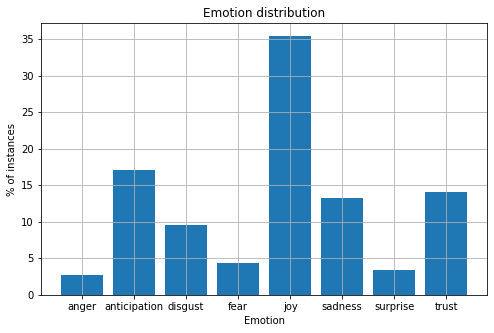

In [18]:
# the histogram of the data
labels = train_data['emotion'].unique()
post_total = len(train_data)
df1 = train_data.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(8,5))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
#plt.savefig('Emotion distribution.png')
plt.show()

## Data preprocessing

In [1]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras import regularizers, initializers, optimizers, callbacks
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import MaxPooling1D,Dropout, LSTM, GRU, Bidirectional, Embedding,Conv1D
from keras.models import Model,Sequential, load_model
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import re
import time

In [7]:
train_data = pd.read_pickle('train_data.pkl')
test_data = pd.read_pickle('test_data.pkl')

''' replace some special text by regularize words 
* EX: @Yalda ===> USER
* EX: 25 times ===> NUM times 
'''

In [8]:
#replace some special text by regularize words
#EX: @Yalda ===> USER , 25 times ===> NUM times ...etc
emailsRegex=re.compile(r'[\w\.-]+@[\w\.-]+')
userMentionsRegex=re.compile(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9]+)')
urlsRegex=re.compile('r(f|ht)(tp)(s?)(://)(.*)[.|/][^ ]+')
numsRegex=re.compile(r"\b\d+\b")

In [9]:
texts = train_data['text']
start = time.time()
texts = texts.apply(lambda a:a.replace("<LH>",""))
texts = texts.apply(lambda a:userMentionsRegex.sub(' USER',a))
texts = texts.apply(lambda a:emailsRegex.sub(' EMAIL',a))
texts = texts.apply(lambda a:urlsRegex.sub(' URL',a))
texts = texts.apply(lambda a:numsRegex.sub(' NUM',a))
print("TIME: %f",time.time()-start)

TIME: %f 21.38380241394043


In [10]:
texts = list(train_data['text'])
labels = list(train_data['emotion'])

## Label one-hot

In [11]:
label_encoder  = preprocessing.LabelEncoder()
label_encoder.fit(labels)
label_classes = label_encoder.classes_
print(label_classes)

['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']


In [12]:
label = label_encoder.transform(labels)
label = to_categorical(np.asarray(label))
print('label shape:', label.shape)

label shape: (1455563, 8)


## Tokenize

In [13]:
start = time.time()
#num_words = 10000
#tokenizer = Tokenizer(num_words=num_words, lower=True)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
print("Time : {:.2f} sec".format(time.time() - start))

Time : 36.59 sec


In [16]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 912661 unique tokens.


In [14]:
## Finding the Large Max length
# count_len=[]
# for i in range(len(sequences)):
#     count_len.append(len(sequences[i]))
# max_len = max(count_len)

In [17]:
max_len=60 #testing data max length
data = pad_sequences(sequences, maxlen=max_len)
print('data shape:', data.shape)

data shape: (1455563, 60)


## Train / Test split
* I split the training validation data with the same random seed every time for comparing which method is better.

In [18]:
# I split the training validation data with the same random seed every time for finding which method is better.
x_train,x_test,y_train,y_test = train_test_split(data, label, test_size=0.25, random_state=20191118)

# Model

### Using pre-trained words embedding (glove).

In [19]:
EMBEDDING_DIM = 100
 
embeddings_index = {}
f = open(r'glove.twitter.27B.100d.txt',encoding="utf-8")
print("Loading GloVe")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print("Done.\nProceeding with Embedding Matrix...")
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print("Completed!")

Loading GloVe
Done.
Proceeding with Embedding Matrix...
Completed!


In [20]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=True)

''' CNN-LSTM model
* First, I didn't do any preprocessing for the data.
* I try to imporve it, so I make some data preprocessing like remove the stop words, special charts, @....  but the result become worse.
* I also try to use LSTM-CNN model instead, but the result is worse then CNN_LSTM model.
'''

In [21]:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm1 = Bidirectional(LSTM(70,dropout=0.4,recurrent_dropout=0.4,return_sequences=True))(embedded_sequences)
l_cov1= Conv1D(100, 3, activation='relu',kernel_regularizer=regularizers.l2(0.02))(l_lstm1)
l_pool1 = MaxPooling1D(2)(l_cov1)
l_drop1 = Dropout(0.4)(l_pool1)
l_flat = Flatten()(l_drop1)
l_dense = Dense(50, activation='relu')(l_flat)
preds = Dense(8, activation='softmax')(l_dense)

model = Model(sequence_input,preds)
adam= optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
#adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 60, 100)           91266200  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 140)           95760     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 58, 100)           42100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 29, 100)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 100)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2900)              0         
__________

In [ ]:
epoch = 50
batch_size = 5000

In [ ]:
#only save the best model.
path = "model/best.h5"
checkpoint = callbacks.ModelCheckpoint(path, monitor='val_acc',verbose=1, save_best_only=True)
csv_logger = callbacks.CSVLogger("model/model_history.csv", separator=',',append=True)

In [ ]:
train_history =model.fit(x_train, y_train, validation_data=(x_test, y_test),
                         epochs=epoch, batch_size=batch_size,callbacks=[checkpoint,csv_logger])

In [ ]:
#Plot the Loss/Acc 
import matplotlib.pyplot as plt 
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.savefig("acc.png")
plt.show()

<img src="img/acc_4.png" style="width: 300px;"/>

## Create submition csv

In [ ]:
texts = list(test_data['text'])
test_sequences = tokenizer.texts_to_sequences(texts)
test = pad_sequences(test_sequences, maxlen=max_len)

In [ ]:
model = load_model('model/best.h5')
predict = model.predict(test,batch_size=batch_size)
pre = np.argmax(predict, axis=1)
result = label_encoder.inverse_transform(pre)
test_data['emotion'] = result
test_data=test_data.drop(['identification','text'],axis=1)
test_data.to_csv('test.csv',index=False)

In [ ]:
# I'm not sure do I need to make the same sequence like sample submission, so I create this one.
sample_dir = "dm20-lab2-nthu/sampleSubmission.csv"
sample = pd.read_csv(sample_dir,index_col='id')
t = pd.read_csv("test.csv",index_col='id')
sample['emotion']=t['emotion']
sample.to_csv('result.csv')

In [22]:
from keras.preprocessing.sequence import pad_sequences
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps
from keras_bert import get_base_dict, get_model, compile_model, gen_batch_inputs
from keras_bert import get_pretrained, PretrainedList, get_checkpoint_paths
from keras_bert import extract_embeddings, POOL_NSP, POOL_MAX
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras.layers import *
from keras.models import Model
import keras.backend as K
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tqdm import tqdm
import re
import time

'''
Bert model:
I do the data preprocessing I mentioned above (EX: @Yalda ===> USER , 25 times ===> NUM times ...etc). Regularize special type of twitter.
'''


In [23]:
config_path = 'cased_L-12_H-768_A-12/bert_config.json'
checkpoint_path = 'cased_L-12_H-768_A-12/bert_model.ckpt'
dict_path = 'cased_L-12_H-768_A-12/vocab.txt'

In [24]:
token_dict = load_vocabulary(dict_path)
tokenizer = Tokenizer(token_dict)

In [27]:
token_sents = []
index_sents = []
for i, sent in tqdm(enumerate(texts)):
    indices, segments = tokenizer.encode(sent)
    token_sents.append(tokenizer.tokenize(sent))
    index_sents.append(indices)

In [ ]:
max_len=200
data = pad_sequences(index_sents, maxlen=max_len,padding='post')
x_train,x_val,y_train,y_val = train_test_split(data, label, test_size=0.25, random_state=20201204)

In [ ]:
x_train = np.array(x_train)
m_train = np.zeros_like(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
m_val = np.zeros_like(x_val)
y_val = np.array(y_val)

In [31]:
bert_model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=None)

In [29]:
num_class=8# change

inputs = bert_model.inputs[:2]
dense = bert_model.layers[-3].output
outputs = Dense(num_class, activation='softmax',name='predict')(dense)

In [30]:
model = Model(inputs,outputs)
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(1e-5),
    metrics=['accuracy']
)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, None)         0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, None, 768),  22268928    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, None, 768)    1536        Input-Segment[0][0]              
__________________________________________________________________________________________________
Embedding-

In [ ]:
epoch = 5
batch_size = 25

In [ ]:
from keras import optimizers, callbacks
filepath = "model/model-{epoch:02d}-{val_acc:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc',verbose=1, save_best_only=True)
csv_logger = callbacks.CSVLogger("model/bert_history.csv", separator=',',append=True)

train_history =model.fit([x_train,m_train], y_train, validation_data=([x_val,m_val], y_val),
                         epochs=epoch, batch_size=batch_size,callbacks=[checkpoint,csv_logger])

### Bert testing

In [ ]:
test_data = pd.read_pickle('test_data.pkl')
test_texts = test_data['text']
start = time.time()
test_texts = test_texts.apply(lambda a:a.replace("<LH>",""))
test_texts = test_texts.apply(lambda a:userMentionsRegex.sub(' USER',a))
test_texts = test_texts.apply(lambda a:emailsRegex.sub(' EMAIL',a))
test_texts = test_texts.apply(lambda a:urlsRegex.sub(' URL',a))
test_texts = test_texts.apply(lambda a:numsRegex.sub(' NUM',a))
print("TIME: %f",time.time()-start)
test_texts = list(test_texts)

test_token_sents = []
test_index_sents = []
for i, sent in tqdm(enumerate(test_texts)):
    indices, segments = tokenizer.encode(sent)
    test_token_sents.append(tokenizer.tokenize(sent))
    test_index_sents.append(indices)

test = pad_sequences(test_index_sents, maxlen=max_len,padding='post')
m_test = np.zeros_like(test)

In [ ]:
from keras_bert import get_custom_objects
model = load_model('model/model-03-0.64.h5', custom_objects=get_custom_objects())
predict = model.predict([test,m_test],batch_size=batch_size)
pre = np.argmax(predict, axis=1)
result = label_encoder.inverse_transform(pre)


test_data['emotion'] = result
df=test_data.drop(['identification','text'],axis=1)
df.to_csv('test.csv',index=False)
sample_dir = "dm20-lab2-nthu/sampleSubmission.csv"
sample = pd.read_csv(sample_dir,index_col='id')
t = pd.read_csv("test.csv",index_col='id')
sample['emotion']=t['emotion']
sample.to_csv('result.csv')